# Mapping - Analysis

---

### Links Used

- [Interpolating data on a grid](https://earthscience.stackexchange.com/questions/12057/how-to-interpolate-scattered-data-to-a-regular-grid-in-python)
- [Interpolating between grids with Basemap](http://earthpy.org/interpolation_between_grids_with_basemap.html)
- [EarthPy - Visualization](http://earthpy.org/category/visualization.html)
- [Counting grids from set of points using numpy](https://gis.stackexchange.com/questions/257466/creating-counting-grid-from-set-of-points-using-numpy)
- [GIS using PyData stack](http://darribas.org/gds_scipy16/gds_scipy16.pdf)
- [**GeoPlot - KDEPlot**](https://residentmario.github.io/geoplot/kdeplot.html#geoplot.kdeplot)
- [Seaborn - KDEPlot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)
- [Visualization with Python, O'Rielly Media](https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html)

### Dependencies

In [17]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.interpolate import griddata
from shapely.geometry import Point

# Plotting
from matplotlib import pyplot as plt
import geoplot as gp

### Objective

`Create a banded heatmap of yearly location activity in Iowa City.`

**Steps:**

1. Basemap class
2. Create gridding interpolation function
    - Get extent of location points (lat/lng)
    - Divide by `n` to number of bins
    - assign points to (`i, j`) bin.
    - return grid with weights

In [2]:
# data file
coords_f = '../data/johnson-cnty-coords.csv'
coords_df = pd.read_csv(coords_f)

coords_df.head()

,timestamp,latitude,longitude,weekday,dayhour,weekend,year,business
0,2016-07-27 10:35:24-05:00,41.683614,-91.504861,Wednesday,10,False,none,True
1,2017-03-17 12:24:27-05:00,41.683686,-91.503358,Friday,12,False,senior,True
2,2016-07-27 10:37:24-05:00,41.683698,-91.504880,Wednesday,10,False,none,True
3,2016-07-27 10:38:25-05:00,41.683710,-91.504871,Wednesday,10,False,none,True
4,2016-07-27 10:28:39.467000-05:00,41.683757,-91.504225,Wednesday,10,False,none,True


### Utils

In [35]:
# IC basemap

# return year
def get_yr_coords(df, year):
    return df[df.year == year]

# create data grid



In [62]:
# Coordinate Extents
lat_extent = [coords_df.latitude.min(),  coords_df.latitude.max()]
lng_extent = [coords_df.longitude.min(), coords_df.longitude.max()]
map_extent = (lng_extent[0], lng_extent[1], lat_extent[0], lat_extent[1])

# Coordinate Ranges
lat_range = lat_extent[1] - lat_extent[0]
lng_range = lng_extent[1] - lng_extent[0]

def create_range_step(extent, num_bins):
    return extent / num_bins

lat_step = create_range_step(lat_range, 500)
lng_step = create_range_step(lng_range, 500)

print ('Extents\n\tLat: {}, Lng: {}'.format(lat_extent, lng_extent))
print ('Ranges\n\tLat: {}, Lng: {}'.format(lat_range, lng_range))
print ('Steps\n\tLat: {}, Lng: {}'.format(lat_step, lng_step))

Extents
	Lat: [41.53943889999999, 41.86075870000001], Lng: [-91.8338444, -91.36904720000001]
Ranges
	Lat: 0.32131980000001903, Lng: 0.46479719999999247
Steps
	Lat: 0.000642639600000038, Lng: 0.0009295943999999849


In [23]:
### GRIDS

# lat is Y
# lng is X
steps_lat = np.arange(lat_extent[0], lat_extent[1], lat_step)
steps_lng = np.arange(lng_extent[0], lng_extent[1], lng_step)

grid_lat, grid_lng = np.meshgrid(steps_lat, steps_lng)

# Coord values (1, because a coordinate is *1* observation)
n = len(coords_df)
ones = np.empty(n)
ones.fill(1)

# Filled grid
#zi = griddata((x,y),z,(xi,yi),method='linear')
z = griddata((coords_df.latitude, coords_df.longitude), ones, (grid_lng, grid_lat), method='linear')

In [27]:
def create_grid(df, numrows=240, numcols=240, method='linear'):
    # Create bins and grid
    xi = np.linspace(df.longitude.min(), df.longitude.max(), numcols)
    yi = np.linspace(df.latitude.min(), df.latitude.max(), numrows)
    xi, yi = np.meshgrid(xi, yi)
    
    # Create values
    n = len(df)
    ones = np.empty(n)
    ones.fill(1)
    
    # Interpolate data grid
    zi = griddata((df.longitude, df.latitude),
                 ones,
                 (xi, yi), method=method)
    return zi

create_grid(coords_df).max()

nan

### Geopandas + GeoPlot

In [47]:
test_df = gpd.GeoDataFrame(
    {
        'value': ones,
        'year': coords_df.year
    },
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(coords_df.longitude, coords_df.latitude)]
)

In [63]:
yr_jr = get_yr_coords(test_df, 'junior')
yr_sr = get_yr_coords(test_df, 'senior')
yr_pg = get_yr_coords(test_df, 'postgrad')

yr_colors = {
    'junior': 'Reds',
    'senior': 'Blues',
    'postgrad': 'Greens'
}

def plot_yr(df, ax):
    year = df.year.unique()[0]
    cmap = yr_colors[year]
    
    gp.kdeplot(
        df.sample(1000),
        extent=map_extent,
        ax=ax,
        kwargs={
            'gridsize': 240,
            'linewidth': 0.1
        }
    )

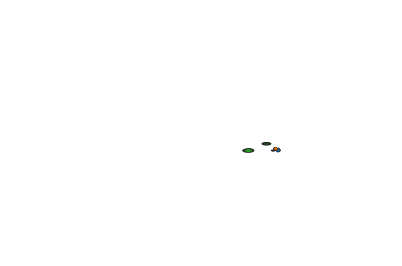

In [64]:
fig, axes = plt.subplots(1)

plot_yr(yr_jr, axes)
plot_yr(yr_sr, axes)
plot_yr(yr_pg, axes)

plt.show()

In [69]:
print (len(coords_df.latitude))
len(coords_df.latitude.unique())

571882


66175

In [66]:
len(coords_df.longitude.unique())

75379

In [68]:
# df1.groupby(['A','B']).size().reset_index().rename(columns={0:'count'})
unique_coords = coords_df.groupby(['longitude', 'latitude']).size().reset_index().rename(columns={0: 'count'})
len(coords_df)

571882

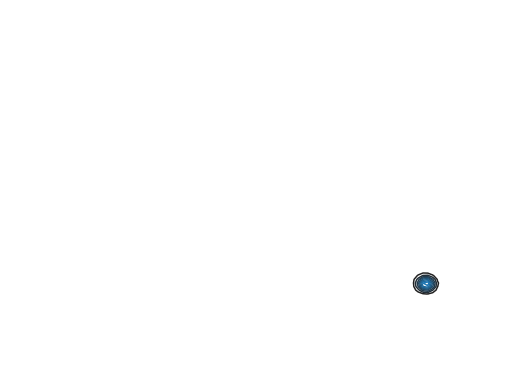

In [55]:
gp.kdeplot(
    test_df[test_df.year == 'junior'].sample(1000),
    #extent=(minx, maxx,...),
    kwargs={
        'gridsize': 240,
        'linewidth': 0.1
    }
)

plt.show()